figures for the 10 minute talk at EARS

In [94]:
from pathlib import Path
import itertools as itt

import joblib as jl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import seaborn as sns
from IPython.display import display
from statannot import add_stat_annotation
from cycler import cycler

from src.data.region_map import region_map
from src.visualization.fancy_plots import savefig


In [2]:
#general plottin formating
plt.style.use('dark_background')

light_color_cycle = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

trans_color_map = {'silence': '#377eb8',  # blue
                   'continuous': '#ff7f00',  # orange
                   'similar': '#4daf4a',  # green
                   'sharp': '#a65628'}  # brown

params = {'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': light_color_cycle,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [4,4],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial',
          'legend.loc': 'upper right',
          'legend.frameon': False,
          'legend.fontsize': 15,
          'legend.markerscale': 3,
          }

widescreen = [13.3, 7.5]

plt.rcParams.update(params)

In [8]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
DF = jl.load(Path(f'../data/210302_consolidated_summary_DF_alpha_0.05/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

# no need for means or mean policy, working on permutations only
ff_probe = DF.probe != 'mean'
ff_pairs = DF.context_pair != 'mean'
ff_stim = DF.stim_type == 'permutations'
ff_mean = DF.mean_signif_type == 'shuffles'

ff_analylis = DF.analysis.isin(['SC', 'fdPCA'])
ff_corr = DF.mult_comp_corr == 'consecutive_3'
ff_metric = DF.metric.isin(['significant_abs_mass_center', 'significant_abs_mean'])

good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
            'probe', 'metric', 'value']
filtered = DF.loc[ff_stim & ff_mean & ff_pairs & ff_probe & ff_analylis & ff_corr & ff_metric, good_cols]

# rename metrics and analysis for ease of ploting
filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'center of mass (ms)',
                                                 'significant_abs_mean': "mean d'",
                                                 'significant_abs_sum': "d' integral"})
filtered['analysis'] = filtered['analysis'].replace({'SC': 'single cell',
                                                     'fdPCA': 'population'})

filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
filtered = filtered.drop(columns=['cellid', 'siteid'])

filtered['value'] = filtered['value'].fillna(value=0)

# creates a new column relating probe with  context pairs
ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
prb = np.asarray(filtered.probe, dtype=int)

silence = ctx == 0
same = ctx == prb[:,None]
different = np.logical_and(~silence, ~same)

name_arr = np.full_like(ctx, np.nan, dtype=object)
name_arr[silence] = 'sile'
name_arr[same] = 'same'
name_arr[different] = 'diff'
comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

# swaps clasification names to not have repetitions i.e. diff_same == same_diff
comp_name_arr[np.where(comp_name_arr == 'self_sile')] = 'sile_self'
comp_name_arr[np.where(comp_name_arr == 'diff_sile')] = 'sile_diff'
comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'
comp_name_arr[np.where(comp_name_arr == 'same_sile')] = 'sile_same'

filtered['trans_pair'] = comp_name_arr

ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()

In [9]:
# counts the total number of values for each comparison (SC, fDPCA) x (sile_diff, sile_same, diff_diff, same_diff)
# counts the proportion of signifciant vs non singificant(zero-zero) values
# decimates the more numerous comparisons??

# set the array to group by id, context_pair, and probe. Keeping analysis, region and transision_pair
# the final array should have analysis, region and trans pair as rowns, and total count, and significants as columns

def nozero_mean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def nozero_count(arr):
    return np.sum(arr>0)

group_ready = pivoted.set_index(['analysis', 'region', 'trans_pair']).loc[:, filtered.metric.unique()]

agg_funcs = {'center of mass (ms)': [('mean duration', nozero_mean)],
             "mean d'": [('mean amplitude', nozero_mean),
                                     ('total', 'size'),
                                     ('n_signif', nozero_count)]}

grouped = group_ready.groupby(['analysis', 'region', 'trans_pair']).agg(agg_funcs)
grouped.columns = grouped.columns.droplevel(0)
grouped['significant %'] = grouped.n_signif / grouped.total * 100

mean duration  mean amplitude  total  n_signif  \
analysis    region trans_pair                                                   
population  A1     diff_diff      105.673710        1.674731    108      38.0   
                   same_diff       86.193536        1.907713    108      30.0   
                   sile_diff      188.616721        1.703010    108      58.0   
                   sile_same      148.695309        1.699413     36      19.0   
            PEG    diff_diff      149.168185        1.571888     96      32.0   
                   same_diff       94.031012        1.588388     96      33.0   
                   sile_diff      142.925743        1.651199     96      52.0   
                   sile_same      138.050211        1.644664     32      19.0   
single cell A1     diff_diff      129.954786        1.253440   3048     167.0   
                   same_diff      137.824877        1.219568   3048     180.0   
                   sile_diff      197.906654        1.170995   3048     265.0   
                   sile_same      225.256465        1.089933   1016      76.0   
            PEG    diff_diff      183.908435        1.170024   2148     146.0   
                   same_diff      213.469746        1.215863   2148     149.0   
                   sile_diff      190.956718        1.202232   2148     175.0   
                   sile_same      201.498936        1.205719    716      67.0   

                               significant %  
analysis    region trans_pair                 
population  A1     diff_diff       35.185185  
                   same_diff       27.777778  
                   sile_diff       53.703704  
                   sile_same       52.777778  
            PEG    diff_diff       33.333333  
                   same_diff       34.375000  
                   sile_diff       54.166667  
                   sile_same       59.375000  
single cell A1     diff_diff        5.479003  
                   same_diff        5.905512  
                   sile_diff        8.694226  
                   sile_same        7.480315  
            PEG    diff_diff        6.797020  
                   same_diff        6.936685  
                   sile_diff        8.147114  
                   sile_same        9.357542

## count of significant instances

In [91]:
# paired relation plot
# defines the grid (5 * 5) with correct indexing

def pairwise_heatmap(value, up_var, lo_var, analysis, ax=None):
    grid_lab = np.asarray(['sile', 'same', 'diff', 'diff', 'diff'])
    grid_arr = np.full((5,5), np.nan)
    swap_dict = {'self_sile': 'sile_self',
                 'diff_sile': 'sile_diff',
                 'diff_same': 'same_diff',
                 'same_sile': 'sile_same'}

    up_idx = np.triu_indices(5,1)
    lo_idx = np.tril_indices(5,-1)

    # relates labes to upper and lower
    upper_label = [f'{grid_lab[t1]}_{grid_lab[t2]}' for t1, t2 in
             zip(up_idx[0], up_idx[1])]

    lower_label = [f'{grid_lab[t1]}_{grid_lab[t2]}' for t1, t2 in
             zip(lo_idx[0], lo_idx[1])]
    lower_label = [swap_dict[lab] if lab in list(swap_dict.keys()) else lab for lab in lower_label]

    # iterates and fills upper triangle
    up_vals = list()
    for uplab in upper_label:
        up_vals.append(grouped.loc[(analysis, up_var, uplab), value])

    lo_vals = list()
    for lolab in lower_label:
        lo_vals.append(grouped.loc[(analysis, lo_var, lolab), value])

    grid_arr[up_idx] = up_vals
    grid_arr[lo_idx] = lo_vals

    if  ax == None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    im = ax.imshow(grid_arr, cmap='viridis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(grid_lab)))
    ax.set_yticks(np.arange(len(grid_lab)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(grid_lab)
    ax.set_yticklabels(grid_lab)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over labelse and  set values the first time
    for unique_lab in set(upper_label):
        uy = up_idx[0][upper_label.index(unique_lab)]
        ux = up_idx[1][upper_label.index(unique_lab)]
        text = ax.text(ux, uy, f'{grid_arr[uy, ux]:.2f}',
                           ha="center", va="center", color="w")

    for unique_lab in set(lower_label):
        ly = lo_idx[0][lower_label.index(unique_lab)]
        lx = lo_idx[1][lower_label.index(unique_lab)]
        text = ax.text(lx, ly, f'{grid_arr[ly, lx]:.2f}',
                           ha="center", va="center", color="w")

    ax.set_title(f"{analysis} {value} ({lo_var}\\{up_var})")
    return fig, ax

# another way of looking at the heatmaps data: lines of sorted percentage significant
def pairwise_lineplot(value, analysis, ax=None):
    toplot = grouped.loc[(analysis), (value)]
    toplot = toplot.reset_index()
    toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
    toplot = toplot.sort_values(by=['A1'], ascending=[True])

    if  ax == None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    norm = matplotlib.colors.Normalize(vmin=toplot.values.min(), vmax=toplot.values.max(), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

    _ = ax.plot(toplot.A1, color='white', linestyle=':', label='A1')
    A1_scat = ax.scatter(range(0, 4),toplot.A1, s=100, c=toplot.A1)
    A1_scat.set_norm(norm)
    ax.plot(toplot.PEG, color='white', linestyle='-', label='PEG')
    PEG_scat =ax.scatter(range(0, 4),toplot.PEG, s=100, c=toplot.PEG)
    PEG_scat.set_norm(norm)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_ylabel('significant %')
    ax.legend(frameon=False, loc='lower right' )
    ax.set_title(f"{analysis} {value} (A1 vs PEG)")
    return fig, ax

### single cell

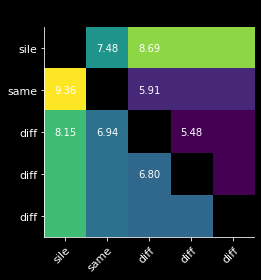

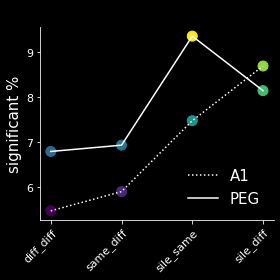

In [95]:
fig, ax = pairwise_heatmap('significant %', 'A1', 'PEG', 'single cell')
ax.set_title(' ')
fig.set_size_inches(4,4)
title = 'single_cell_signig_percent_heatmap'
savefig(fig, 'EARS_figures', title)



fig, ax = pairwise_lineplot('significant %', 'single cell')
ax.set_title(' ')
fig.set_size_inches(4,4)
title = 'single_cell_signig_percent_plot'
savefig(fig, 'EARS_figures', title)

### population

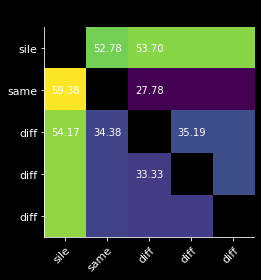

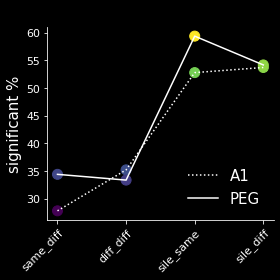

In [96]:
fig, ax = pairwise_heatmap('significant %', 'A1', 'PEG', 'population')
ax.set_title(' ')
fig.set_size_inches(4,4)
title = 'population_signig_percent_heatmap'
savefig(fig, 'EARS_figures', title)


fig, ax = pairwise_lineplot('significant %', 'population')
ax.set_title(' ')
fig.set_size_inches(4,4)
title = 'population_signig_percent_plot'
savefig(fig, 'EARS_figures', title)

In [16]:
trans_ord = ['diff_diff', 'same_diff', 'sile_same', 'sile_diff']
reg_ord = ['A1', 'PEG']
ana_ord = ['single cell', 'population']

In [14]:
# grid with proportion anotations
def anotated_nozero_scatter(x, y, **kws):
    total = x.shape[0]
    x = x[x>0]
    y = y[y>0]
    region = kws.get('label', 'PEG')
    fontsize = kws.pop('fontsize', 12)
    n_signif = len(x)
    percent_good = n_signif / total * 100

    ax = plt.gca()
    ax.scatter(x, y, s=15, alpha=0.3, **kws)
    sns.kdeplot(x, y, ax=ax,**kws)
    ax.set_xlim(0,ax.get_xlim()[1])
    ax.set_ylim(0,ax.get_ylim()[1])

    offset = 0.8 if region == 'A1' else 0.9
    ax.text(.2, offset, f'n {total}, {percent_good:.2f}% signif', fontsize=fontsize, transform=ax.transAxes, **kws)


# plots showing the progression of the date split (for single cell)

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  from ipykernel import kernelapp as app


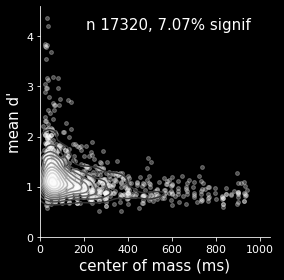

In [40]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]


g = sns.FacetGrid(data=scDF, row=None, col=None, hue=None,
                  sharex=True, sharey=True, legend_out=True,
                  row_order=ana_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "mean d'", color='white', fontsize=15)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(4,4)
fig.tight_layout(rect=(0,0,0.98,0))

title = 'parameter_space_pooled'
savefig(fig, 'EARS_figures', title)

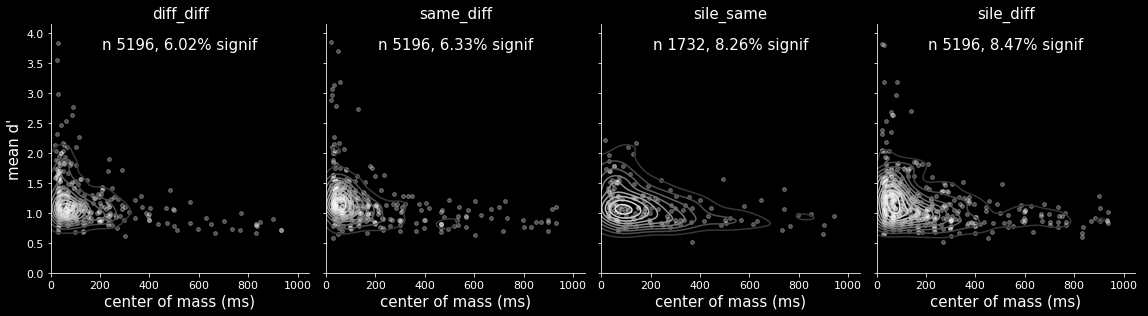

In [43]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]
g = sns.FacetGrid(data=scDF, row=None, col='trans_pair', hue=None,
                  sharex=True, sharey=True, legend_out=True,
                  row_order=ana_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "mean d'", color='white', fontsize=15)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(16,4.5)
fig.tight_layout(rect=(0,0,1,1))

title = 'parameter_space_transitions'
savefig(fig, 'EARS_figures', title)


/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':


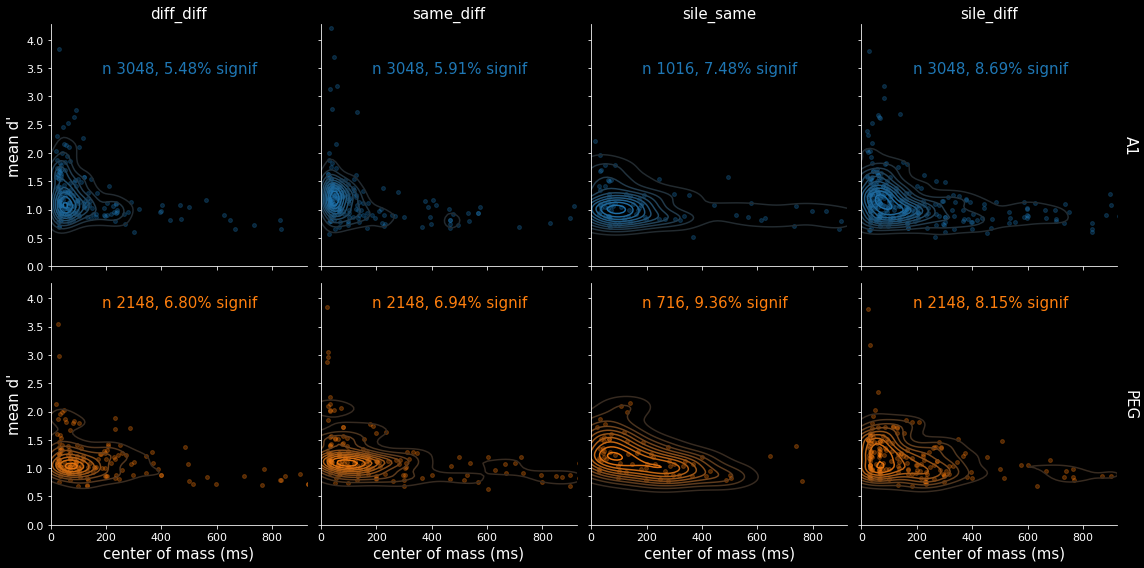

In [44]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]
g = sns.FacetGrid(data=scDF, row='region', col='trans_pair', hue='region',
                  sharex=True, sharey=True, legend_out=True,
                  row_order=reg_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "mean d'", fontsize=15)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
# g.add_legend()
fig = g.fig
fig.set_size_inches(16,8)
fig.tight_layout(rect=(0,0,0.98,0))

title = 'parameter_space_trans_region'
savefig(fig, 'EARS_figures', title)

# Anova tables

In [53]:
for ana, met in itt.product(['single cell', 'population'], ['center of mass (ms)', "mean d'"]):
    ff_metric = filtered.metric == met
    ff_analysis = filtered.analysis == ana
    ff_val = filtered.value > 0
    anovaDF =  filtered.loc[ff_metric & ff_analylis & ff_val,
                         ['region', 'trans_pair', 'value']]

    model = ols('value ~ C(region) + C(trans_pair) + C(region):C(trans_pair)', data=anovaDF).fit()
    df = sm.stats.anova_lm(model, typ=2)

    title =f'\n {ana} {met}'
    print(title)
    display(df)



 single cell center of mass (ms)

 single cell mean d'

 population center of mass (ms)

 population mean d'


,sum_sq,df,F,PR(>F)
C(region),2.572391e+05,1.0,6.421914,0.011397
C(trans_pair),5.033607e+05,3.0,4.188760,0.005834
C(region):C(trans_pair),4.611779e+05,3.0,3.837732,0.009465
Residual,4.874871e+07,1217.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(region),0.001260,1.0,0.006508,0.935714
C(trans_pair),0.717398,3.0,1.234939,0.295648
C(region):C(trans_pair),1.122115,3.0,1.931625,0.122632
Residual,235.658897,1217.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(region),2.572391e+05,1.0,6.421914,0.011397
C(trans_pair),5.033607e+05,3.0,4.188760,0.005834
C(region):C(trans_pair),4.611779e+05,3.0,3.837732,0.009465
Residual,4.874871e+07,1217.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(region),0.001260,1.0,0.006508,0.935714
C(trans_pair),0.717398,3.0,1.234939,0.295648
C(region):C(trans_pair),1.122115,3.0,1.931625,0.122632
Residual,235.658897,1217.0,NaN,NaN


# post hoc comparisons
## single cell

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


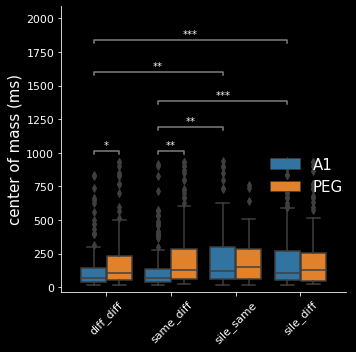

In [123]:
toplot = filtered.loc[(filtered.metric == 'center of mass (ms)') &
                      (filtered.analysis == 'single cell') &
                      (filtered.value >0),:]


# area_pairs = [((trans, 'A1'), (trans, 'PEG')) for trans in toplot.trans_pair.unique()]
# trans_pairs = [((tp1, reg), (tp2, reg)) for (tp1, tp2), reg
#             in itt.product(itt.combinations(toplot.trans_pair.unique(),2), toplot.region.unique())]

area_pairs = [(('diff_diff', 'A1'), ('diff_diff', 'PEG')),
              (('same_diff', 'A1'), ('same_diff', 'PEG'))]

trans_pairs = [(('diff_diff', 'A1'), ('sile_diff', 'A1')),
               (('diff_diff', 'A1'), ('sile_same', 'A1')),
               (('same_diff', 'A1'), ('sile_diff', 'A1')),
               (('same_diff', 'A1'), ('sile_same', 'A1'))]

pairs = area_pairs + trans_pairs


def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax,
                     order=trans_ord, hue_order=reg_ord,
                     palette=sns.color_palette(), **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=reg_ord,
                            box_pairs=pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, **kws)


g = sns.FacetGrid(row=None, col='metric',data=toplot,
                  sharey=False, sharex=True, legend_out=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='region')

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()

fig = g.fig
axes = g.axes
axes[0,0].set_ylabel(axes[0,0].get_title())
axes[0,0].set_title("")
fig.tight_layout(rect=(0,0,1,1))
fig.set_size_inches(5,5)
title ='single_cell_post_hoc_interaction'
savefig(fig, "EARS_figures", title)

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


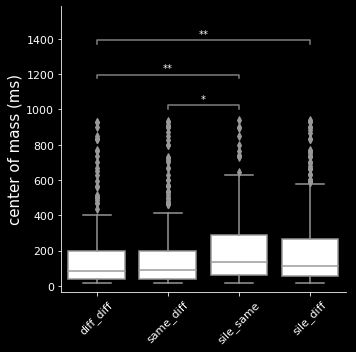

In [125]:
# trans_pp = [(tp1, tp2) for tp1, tp2
#             in itt.combinations(toplot.trans_pair.unique(),2)]

trans_pp = [('diff_diff', 'sile_diff'), ('diff_diff', 'sile_same'), ('same_diff', 'sile_same')]
def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax, order=trans_ord, palette=['white'], **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord,
                            box_pairs=trans_pp,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row=None, col='metric',data=toplot,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value')

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()

fig = g.fig
axes = g.axes
axes[0,0].set_ylabel(axes[0,0].get_title())
axes[0,0].set_title("")
fig.tight_layout(rect=(0,0,1,1))
fig.set_size_inches(5,5)
title ='single_cell_post_hoc_trans_pair'
savefig(fig, "EARS_figures", title)

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


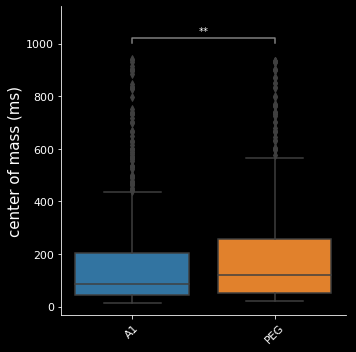

In [132]:
# trans_pp = [(tp1, tp2) for tp1, tp2
#             in itt.combinations(toplot.trans_pair.unique(),2)]

region_pairs = [('A1','PEG')]
def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax, order=reg_ord, palette=sns.color_palette(), **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=reg_ord,
                            box_pairs=region_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row=None, col='metric',data=toplot,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='region', y='value')

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()

fig = g.fig
axes = g.axes
axes[0,0].set_ylabel(axes[0,0].get_title())
axes[0,0].set_title("")
fig.tight_layout(rect=(0,0,1,1))
fig.set_size_inches(5,5)
title ='single_cell_post_hoc_region'
savefig(fig, "EARS_figures", title)

## population


/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator


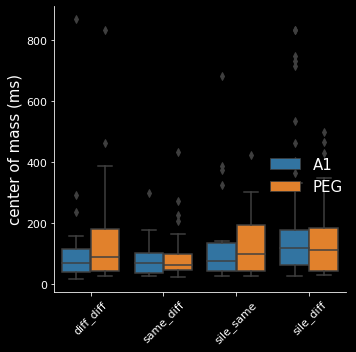

In [139]:
analysis = 'population'
toplot = filtered.loc[(filtered.metric == 'center of mass (ms)') &
                      (filtered.analysis == analysis) &
                      (filtered.value >0),:]


area_pairs = [((trans, 'A1'), (trans, 'PEG')) for trans in toplot.trans_pair.unique()]
trans_pairs = [((tp1, reg), (tp2, reg)) for (tp1, tp2), reg
            in itt.product(itt.combinations(toplot.trans_pair.unique(),2), toplot.region.unique())]

# area_pairs = [(('diff_diff', 'A1'), ('diff_diff', 'PEG')),
#               (('same_diff', 'A1'), ('same_diff', 'PEG'))]
#
# trans_pairs = [(('diff_diff', 'A1'), ('sile_diff', 'A1')),
#                (('diff_diff', 'A1'), ('sile_same', 'A1')),
#                (('same_diff', 'A1'), ('sile_diff', 'A1')),
#                (('same_diff', 'A1'), ('sile_same', 'A1'))]

pairs = area_pairs + trans_pairs


def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax,
                     order=trans_ord, hue_order=reg_ord,
                     palette=sns.color_palette(), **kws)
    kws['color'] = 'gray'
    # _ = add_stat_annotation(ax, plot='boxplot', data=data,
    #                         order=trans_ord, hue_order=reg_ord,
    #                         box_pairs=pairs,
    #                         test='Mann-Whitney', text_format='star',
    #                         loc='inside', verbose=0, **kws)


g = sns.FacetGrid(row=None, col='metric',data=toplot,
                  sharey=False, sharex=True, legend_out=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='region')

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()

fig = g.fig
axes = g.axes
axes[0,0].set_ylabel(axes[0,0].get_title())
axes[0,0].set_title("")
fig.tight_layout(rect=(0,0,1,1))
fig.set_size_inches(5,5)
title =f'{analysis}_post_hoc_interaction'
savefig(fig, "EARS_figures", title)

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


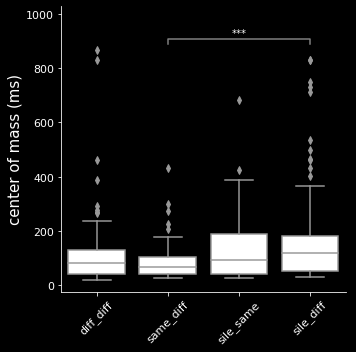

In [141]:
# trans_pp = [(tp1, tp2) for tp1, tp2
#             in itt.combinations(toplot.trans_pair.unique(),2)]

trans_pp = [('same_diff', 'sile_diff')]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax, order=trans_ord, palette=['white'], **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord,
                            box_pairs=trans_pp,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row=None, col='metric',data=toplot,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value')

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()

fig = g.fig
axes = g.axes
axes[0,0].set_ylabel(axes[0,0].get_title())
axes[0,0].set_title("")
fig.tight_layout(rect=(0,0,1,1))
fig.set_size_inches(5,5)
title =f'{analysis}_post_hoc_trans_pair'
savefig(fig, "EARS_figures", title)

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


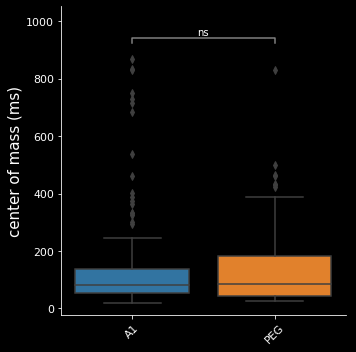

In [144]:
toplot = filtered.loc[(filtered.metric == 'center of mass (ms)') &
                      (filtered.analysis == analysis) &
                      (filtered.value >0),:]

# trans_pp = [(tp1, tp2) for tp1, tp2
#             in itt.combinations(toplot.trans_pair.unique(),2)]

region_pairs = [('A1','PEG')]
def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax, order=reg_ord, palette=sns.color_palette(), **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=reg_ord,
                            box_pairs=region_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row=None, col='metric',data=toplot,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='region', y='value')

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()

fig = g.fig
axes = g.axes
axes[0,0].set_ylabel(axes[0,0].get_title())
axes[0,0].set_title("")
fig.tight_layout(rect=(0,0,1,1))
fig.set_size_inches(5,5)
title =f'{analysis}_post_hoc_region'
savefig(fig, "EARS_figures", title)